In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import tikzplotlib
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import kmapper as km

from kmapper import jupyter
from itertools import cycle
from sklearn import metrics
from collections import OrderedDict
from sklearn.cluster import KMeans, AgglomerativeClustering, OPTICS
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

sns.set_style('darkgrid')

## Load extracted features

In [2]:
DATASET_NAME = "tokens"
FIGURES = "./figures"

In [3]:
# Load code vectors and labels
vectors = pd.read_csv(f'./data/{DATASET_NAME}/{DATASET_NAME}.test.c2v.vectors', sep=" ", header=None)
labels = pd.read_csv(f'./data/{DATASET_NAME}/{DATASET_NAME}.test.c2v', sep=" ").iloc[:, 0]

embedding_shape = vectors.values.shape[1]

# Merge vectors and labels
df = vectors.assign(label=labels)
df.dropna(inplace=True)
# df['count'] = df.groupby('label')['label'].transform('count')
# df = df[(df['count'] >= 100) & (df['count'] <= 3000)].reset_index()
df.head()

/home/marcus/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,35

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,label
0,0.861573,-0.805925,-0.223937,0.135395,0.511780,-0.321722,0.394130,-0.632198,0.053867,-0.481735,...,-0.981503,-0.848984,-0.771564,-0.062339,0.850672,-0.477261,0.830958,0.838055,0.184865,check|macro
1,-0.947588,-0.809216,-0.999865,0.926311,-0.837711,-0.193815,-0.811081,0.973474,0.817187,-0.816424,...,-0.397579,0.972104,0.999260,-0.928836,0.951407,-0.831191,0.838195,0.386540,-0.806765,segmaps|aug
2,-0.792445,-0.804914,-0.876316,0.615241,-0.627391,0.993314,-0.021055,-0.799043,-0.780307,-0.410733,...,0.499657,-0.975526,0.665821,0.984356,0.545434,0.401437,-0.520022,-0.927338,-0.600687,test|item|to|tf|feature|incorrect|shape
3,-0.885332,-0.877435,-0.535447,-0.912271,-0.851135,0.830848,0.935344,-0.851897,-0.818506,0.885595,...,0.397131,-0.755221,-0.817556,-0.063872,-0.817404,-0.091763,-0.648731,-0.837348,0.569150,from|json
4,-0.765936,0.737175,-0.947362,-0.435825,-0.862282,-0.817710,-0.723930,-0.893526,-0.762979,-0.884146,...,0.782193,-0.755660,-0.634666,0.728628,-0.556538,0.681814,0.971339,-0.875257,-0.795443,test|spacy|intent|featurizer


In [4]:
train_df, test_df = train_test_split(df, test_size=0.2) 

In [5]:
train_features = train_df.iloc[:, 0:embedding_shape].values
test_features = test_df.iloc[:, 0:embedding_shape].values

In [6]:
train_features.shape

(93272, 128)

In [7]:
test_features.shape

(23319, 128)

## Reduce Dimensionality with an Autoencoder

In [8]:
class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim   
        self.encoder = tf.keras.Sequential([
          layers.Flatten(),
          layers.Dense(latent_dim, activation='relu'),
        ])
        self.decoder = tf.keras.Sequential([
          layers.Dense(embedding_shape, activation='sigmoid')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [9]:
## Train autoencoder

latent_dim = 10
autoencoder = Autoencoder(latent_dim)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

autoencoder.fit(train_features, train_features,
                epochs=20,
                shuffle=True,
                validation_data=(test_features, test_features),
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3)])

Epoch 1/20
2915/2915 [==============================] - 4s 1ms/step - loss: 0.4758 - val_loss: 0.3866
Epoch 2/20
2915/2915 [==============================] - 3s 950us/step - loss: 0.3850 - val_loss: 0.3796
Epoch 3/20
2915/2915 [==============================] - 3s 976us/step - loss: 0.3788 - val_loss: 0.3772
Epoch 4/20
2915/2915 [==============================] - 3s 1ms/step - loss: 0.3776 - val_loss: 0.3761
Epoch 5/20
2915/2915 [==============================] - 3s 915us/step - loss: 0.3761 - val_loss: 0.3753
Epoch 6/20
2915/2915 [==============================] - 3s 912us/step - loss: 0.3743 - val_loss: 0.3745
Epoch 7/20
2915/2915 [==============================] - 3s 917us/step - loss: 0.3736 - val_loss: 0.3738
Epoch 8/20
2915/2915 [==============================] - 3s 912us/step - loss: 0.3731 - val_loss: 0.3733
Epoch 9/20
2915/2915 [==============================] - 3s 915us/step - loss: 0.3732 - val_loss: 0.3730
Epoch 10/20
2915/2915 [==============================] - 3s 920us/st

In [10]:
# Choose subset of methods to evaluate clusters for
cats = ['predict', 'save', 'train', 'transform']
k = len(cats)

In [11]:
# Create dataframe with high dimensional features of the subset
high_dim_subset_df = df.copy()
high_dim_subset_df = high_dim_subset_df[df.label.isin(cats)]
high_dim_subset_df.label = pd.Categorical(high_dim_subset_df.label)
high_dim_subset_df['category'] = high_dim_subset_df.label.cat.codes
high_dim_features = high_dim_subset_df.iloc[:, 0:embedding_shape].values

In [12]:
# Create dataframe with low dimensional features of the subset using the encoder
low_dim_df = pd.DataFrame(autoencoder.encoder(df.iloc[:, 0:embedding_shape].values).numpy())
low_dim_df = low_dim_df.assign(label=labels)
low_dim_df

,0,1,2,3,4,5,6,7,8,9,label
0,7.673397,10.940156,6.153099,2.134119,7.321599,5.551208,3.335016,7.898863,7.177000,7.741511,check|macro
1,7.271512,6.818431,6.251674,4.535482,0.000000,7.029565,3.175301,2.812427,5.830435,9.288807,segmaps|aug
2,6.602481,5.129969,2.782103,4.606668,4.603536,6.241543,10.596914,6.115900,9.036053,6.844975,test|item|to|tf|feature|incorrect|shape
3,2.890709,1.559761,3.327190,4.404665,7.456917,4.434782,15.451662,1.813346,0.850296,2.306853,from|json
4,6.501083,10.680095,4.596545,9.692089,4.183353,2.535395,5.174541,7.865020,5.780501,7.405384,test|spacy|intent|featurizer
...,...,...,...,...,...,...,...,...,...,...,...
116586,3.892542,4.221537,3.567416,4.993889,7.620633,10.050459,4.875763,13.116301,6.475209,9.493526,add|symbol
116587,5.911427,6.756313,3.934333,1.548797,5.364422,2.784522,3.797892,9.875267,6.879750,7.037688,test|ary|persistency|in|shuffling
116588,4.321820,3.375250,7.829311,2.218296,2.052194,5.303485,10.400478,8.524164,0.907760,1.985000,get|comparison|image
116589,6.619748,2.698610,11.085002,4.928521,0.000000,1.146444,1.541124,5.151159,3.346807,4.008138,test|replacement


In [13]:
low_dim_subset_df = low_dim_df.copy()
low_dim_subset_df = low_dim_subset_df[low_dim_df.label.isin(cats)]
# Assign numerical values for each category
low_dim_subset_df.label = pd.Categorical(low_dim_subset_df.label)
low_dim_subset_df['category'] = low_dim_subset_df.label.cat.codes
unique_labels = dict( enumerate(low_dim_subset_df['label'].cat.categories ) )
print(f"Unique labels:{unique_labels}\nNumber of samples {len(low_dim_subset_df)}")
low_dim_subset_df.groupby('category').size()

Unique labels:{0: 'predict', 1: 'save', 2: 'train', 3: 'transform'}
Number of samples 1110


category
0    410
1    183
2    253
3    264
dtype: int64

In [14]:
low_dim_features = low_dim_subset_df.iloc[:, 0:latent_dim].values

In [15]:
# Use tSNE & clustering
tsne = TSNE(n_components=3, verbose=1, perplexity=30, n_iter=3000)
tsne_result = tsne.fit_transform(low_dim_features)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1110 samples in 0.001s...
[t-SNE] Computed neighbors for 1110 samples in 0.033s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1110
[t-SNE] Computed conditional probabilities for sample 1110 / 1110
[t-SNE] Mean sigma: 3.042791
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.311234
[t-SNE] KL divergence after 2050 iterations: 1.035486


In [16]:
def plot_clusters(estimator, dataframe, labels):
    # Get features from dataframe
    features = dataframe.iloc[:, 0:latent_dim].values
    
    k = len(np.unique(labels))
    # Print metrics
    print('Number of clusters: %d' % k)
    print("Homogeneity: %0.3f" % metrics.homogeneity_score(dataframe['category'], labels))
    print("Completeness: %0.3f" % metrics.completeness_score(dataframe['category'], labels))
    print("V-measure: %0.3f" % metrics.v_measure_score(dataframe['category'], labels))
    print("Adjusted Rand Index: %0.3f"
          % metrics.adjusted_rand_score(dataframe['category'], labels))
    print("Adjusted Mutual Information: %0.3f"
          % metrics.adjusted_mutual_info_score(dataframe['category'], labels))
    print("Jaccard Coefficients: %s"
          % metrics.jaccard_score(dataframe['category'], labels, average=None))
    print("Silhouette Coefficient: %0.3f"
          % metrics.silhouette_score(features, labels, metric='sqeuclidean'))

    # Visualize clusters with tSNE
    fig = plt.figure(figsize=(14,5))
    fig.suptitle('Visualizing clusters with tSNE')
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.set_title(f'{estimator.__class__.__name__} Clusters (k={k})')
    colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
    ax1.scatter(tsne_result[:, 0], tsne_result[:, 1], tsne_result[:, 2], c='k', marker='+', alpha=0.1)
    for klass, color in zip(range(0, k), colors):
        Xk = tsne_result[labels == klass]
        ax1.scatter(Xk[:, 0], Xk[:, 1], Xk[:, 2], c=color, alpha=0.3)

    ax2 = fig.add_subplot(122, projection='3d')
    ax2.set_title('True labels')
    colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
    for klass, color in zip(range(0, len(unique_labels)), colors):
        Xk = tsne_result[low_dim_subset_df['category'] == klass]
        ax2.scatter(Xk[:, 0], Xk[:, 1],  Xk[:, 2], c=color, alpha=0.3, label=unique_labels[klass])
    ax2.legend()
    
    tikzplotlib.save(f"{FIGURES}/code2vec_{DATASET_NAME}_{estimator.__class__.__name__}.tex")
    
    
def cv_silhouette_scorer(estimator, X):
    estimator.fit(X)
    if (estimator.__class__.__name__ == "OPTICS"):
        cluster_labels = estimator.labels_[estimator.ordering_]
    else:
        cluster_labels = estimator.labels_
    num_labels = len(set(cluster_labels))
    num_samples = len(X.index)
    if num_labels == 1 or num_labels == num_samples:
        return -1
    else:
        return metrics.silhouette_score(X, cluster_labels, metric='sqeuclidean')

def get_estimator_name(estimator):
    return estimator.__class__.__name__

In [17]:
estimators = OrderedDict()

## Centroid-based clustering using K-means

Best silhouette score 0.288 achieved with 2 clusters
Number of clusters: 2
Homogeneity: 0.001
Completeness: 0.001
V-measure: 0.001
Adjusted Rand Index: 0.000
Adjusted Mutual Information: -0.000
Jaccard Coefficients: [0.2493188  0.13419913 0.         0.        ]
Silhouette Coefficient: 0.288


<IPython.core.display.Javascript object>


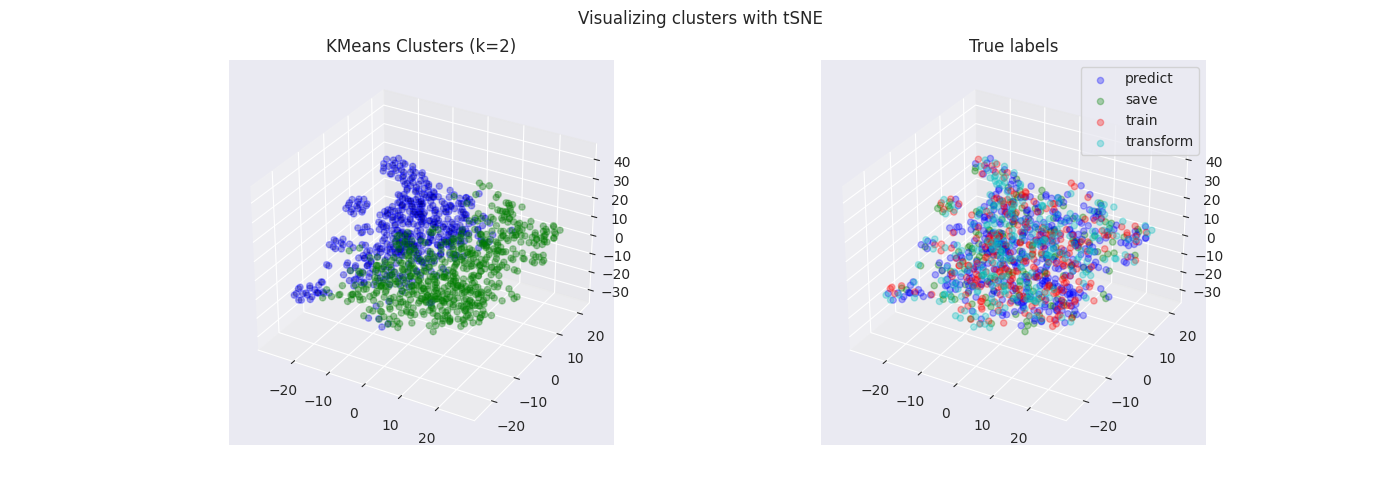

In [18]:
# Apply K-means
search_params = {'n_clusters': np.arange(2,11)}

cv = [(slice(None), slice(None))] # Disable cv, only want grid search
gs = GridSearchCV(estimator=KMeans(random_state=0), param_grid=search_params, 
                  scoring=cv_silhouette_scorer, cv=cv, n_jobs=-1)

res = gs.fit(X=low_dim_subset_df.iloc[:, 0:latent_dim], y=None)

max_silhouette_score = np.max(res.cv_results_['mean_test_score'])
ind = np.argmax(res.cv_results_['mean_test_score'])
k = search_params['n_clusters'][ind]

print(f"Best silhouette score {max_silhouette_score:.3f} achieved with {k} clusters")
kmeans_estimator = KMeans(n_clusters=k, random_state=0)
estimators[get_estimator_name(kmeans_estimator)] = { 'estimator': kmeans_estimator, 'score':  max_silhouette_score }

kmeans = kmeans_estimator.fit(low_dim_features)
plot_clusters(kmeans, low_dim_subset_df, kmeans.labels_)

## Density-Based Clustering using OPTICS

Best silhouette score 0.034 achieved with {'metric': 'minkowski', 'min_samples': 30}
Number of clusters: 2
Homogeneity: 0.001
Completeness: 0.007
V-measure: 0.002
Adjusted Rand Index: -0.003
Adjusted Mutual Information: -0.000
Jaccard Coefficients: [0.         0.05630631 0.         0.         0.        ]
Silhouette Coefficient: 0.034


<IPython.core.display.Javascript object>


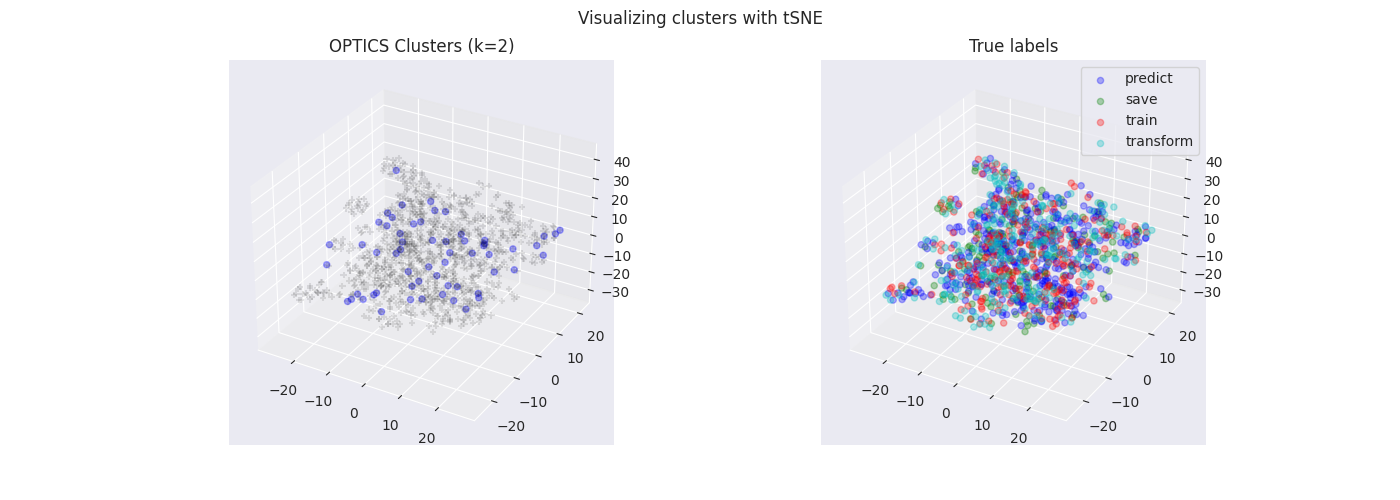

In [19]:
search_params = {'min_samples': [5,10,15,20,25,30], 'metric': ['minkowski', 'cosine', 'euclidean', 'sqeuclidean']}

cv = [(slice(None), slice(None))] # Disable cv, only want grid search
gs = GridSearchCV(estimator=OPTICS(cluster_method='xi'), param_grid=search_params, 
                  scoring=cv_silhouette_scorer, cv=cv, n_jobs=-1)

res = gs.fit(X=low_dim_subset_df.iloc[:, 0:latent_dim], y=None)

# Get best configuration
max_silhouette_score = np.max(res.cv_results_['mean_test_score'])
ind = np.argmax(res.cv_results_['mean_test_score'])
best_params = res.cv_results_['params'][ind]
k = best_params['min_samples']
metric = best_params['metric']

# Visualize best clusters
print(f"Best silhouette score {max_silhouette_score:.3f} achieved with {res.cv_results_['params'][ind]}")
optics_estimator = OPTICS(cluster_method='xi', min_samples=k, metric=metric)
estimators[get_estimator_name(optics_estimator)] = { 'estimator': optics_estimator, 'score':  max_silhouette_score }

optics_clusters = optics_estimator.fit(low_dim_features)
plot_clusters(optics_clusters, low_dim_subset_df, optics_clusters.labels_[optics_clusters.ordering_])

## Agglomerative Clustering (Hierarchical)

Best silhouette score 0.424 achieved with {'affinity': 'euclidean', 'linkage': 'average', 'n_clusters': 2}
Number of clusters: 2
Homogeneity: 0.002
Completeness: 0.010
V-measure: 0.003
Adjusted Rand Index: 0.002
Adjusted Mutual Information: 0.001
Jaccard Coefficients: [0.36663525 0.03265306 0.         0.        ]
Silhouette Coefficient: 0.424


<IPython.core.display.Javascript object>


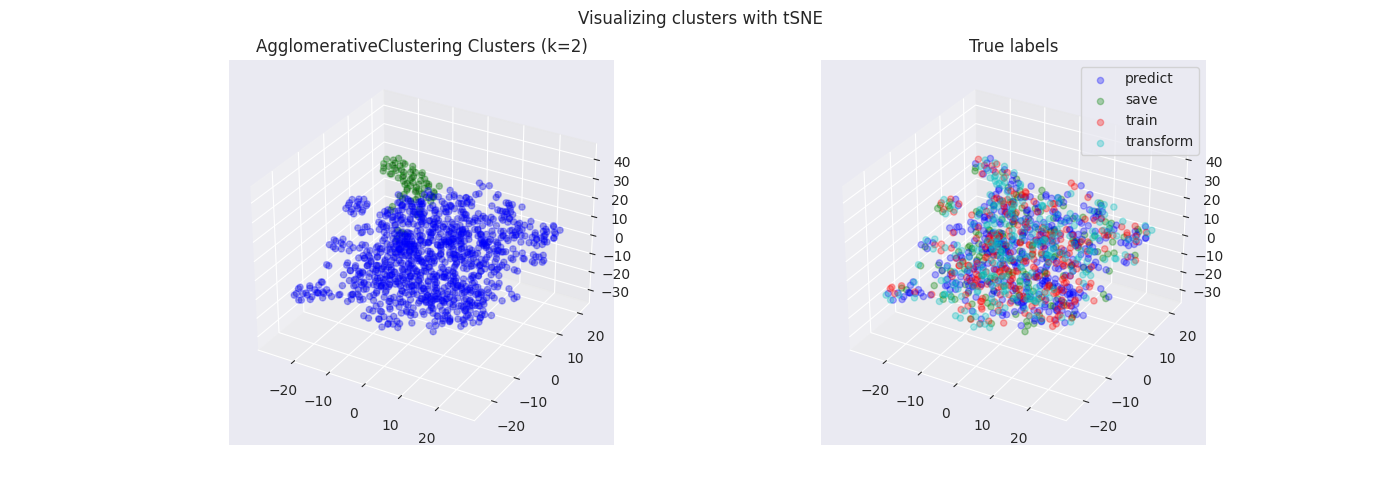

In [20]:
# search_params = {'n_clusters': [2,3,4,5,6,7,8], 'linkage': ['ward', 'complete', 'average', 'single']}
search_params = {'n_clusters': np.arange(2,11), 'linkage': ['complete', 'average', 'single'], 'affinity': ['euclidean', 'l1', 'l2', 'manhattan', 'cosine']}

cv = [(slice(None), slice(None))] # Disable cv, only want grid search
gs = GridSearchCV(estimator=AgglomerativeClustering(linkage='ward'), param_grid=search_params, 
                  scoring=cv_silhouette_scorer, cv=cv, n_jobs=-1)

res = gs.fit(X=low_dim_subset_df.iloc[:, 0:latent_dim], y=None)

# Get best configuration
max_silhouette_score = np.max(res.cv_results_['mean_test_score'])
ind = np.argmax(res.cv_results_['mean_test_score'])
best_params = res.cv_results_['params'][ind]
k = best_params['n_clusters']
linkage = best_params['linkage']

# Visualize best clusters
print(f"Best silhouette score {max_silhouette_score:.3f} achieved with {res.cv_results_['params'][ind]}")
agglomerative_estimator = AgglomerativeClustering(n_clusters=k, linkage=linkage)
estimators[get_estimator_name(agglomerative_estimator)] = { 'estimator': agglomerative_estimator, 'score':  max_silhouette_score}

agglomerative_clusters = agglomerative_estimator.fit(low_dim_features)
plot_clusters(agglomerative_clusters, low_dim_subset_df, agglomerative_clusters.labels_)

## Select best estimator

In [21]:
scores = [val['score'] for val in estimators.values()]
ind = np.argmax(scores)
best_estimator = list(estimators.values())[ind]['estimator']

In [22]:
print(f"Best cluster method: {get_estimator_name(best_estimator)}\nParams:\n{best_estimator.__dict__}")

Best cluster method: AgglomerativeClustering
Params:
{'n_clusters': 2, 'distance_threshold': None, 'memory': None, 'connectivity': None, 'compute_full_tree': 'auto', 'linkage': 'average', 'affinity': 'euclidean', 'compute_distances': False, 'n_features_in_': 10, 'children_': array([[ 774, 1040],
       [ 430, 1051],
       [  50,   74],
       ...,
       [2052, 2215],
       [2213, 2216],
       [2201, 2217]]), 'n_connected_components_': 1, 'n_leaves_': 1110, 'n_clusters_': 2, 'labels_': array([0, 0, 0, ..., 0, 0, 0])}


## Visualize Clusters with Kepler Mapper

In [23]:
# Visualize with kepler map
mapper = km.KeplerMapper(verbose=1)

# Fit and transform data, use TSNE 
projected_data = mapper.fit_transform(low_dim_features, projection=TSNE(n_components=2))

# Create the graph (we cluster on the projected data and suffer projection loss)
graph = mapper.map(
    projected_data,
    clusterer=best_estimator,
#     clusterer=agglomerative_estimator,
    cover=km.Cover(5, 0.3),
)

# Create the visualizations
print("Output graph examples to html")
mapper.visualize(
    graph,
    title=f"{DATASET_NAME} Mapper",
    path_html=f"./data/{DATASET_NAME}/{DATASET_NAME}_visualization.html",
    custom_tooltips=low_dim_subset_df['label'].values
)

jupyter.display(path_html=f"./data/{DATASET_NAME}/{DATASET_NAME}_visualization.html")

KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: TSNE()
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (1110, 10)

..Projecting data using: 
	TSNE(verbose=1)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1110 samples in 0.001s...
[t-SNE] Computed neighbors for 1110 samples in 0.033s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1110
[t-SNE] Computed conditional probabilities for sample 1110 / 1110
[t-SNE] Mean sigma: 3.042791
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.312332
[t-SNE] KL divergence after 1000 iterations: 1.231256

..Scaling with: MinMaxScaler()

Mapping on data shaped (1110, 2) using lens shaped (1110, 2)

Creating 25 hypercubes.

Created 91 edges and 44 nodes in 0:00:00.016227.
Output graph examples to html
Wrote visualization to: ./data/tokens/tokens_visualization.html


/home/marcus/.local/lib/python3.8/site-packages/IPython/core/display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


## Self-Organizing Map

In [24]:
# from tf_som import SelfOrganizingMap
# from sklearn.preprocessing import StandardScaler
# import logging
# from scipy.spatial import distance_matrix

In [25]:
# def get_umatrix(input_vects, weights, m, n):
#     """ Generates an n x m u-matrix of the SOM's weights and bmu indices of all the input data points
#     Used to visualize higher-dimensional data. Shows the average distance between a SOM unit and its neighbors.
#     When displayed, areas of a darker color separated by lighter colors correspond to clusters of units which
#     encode similar information.
#     :param weights: SOM weight matrix, `ndarray`
#     :param m: Rows of neurons
#     :param n: Columns of neurons
#     :return: m x n u-matrix `ndarray` 
#     :return: input_size x 1 bmu indices 'ndarray'
#     """
#     umatrix = np.zeros((m * n, 1))
#     # Get the location of the neurons on the map to figure out their neighbors. I know I already have this in the
#     # SOM code but I put it here too to make it easier to follow.
#     neuron_locs = list()
#     for i in range(m):
#         for j in range(n):
#             neuron_locs.append(np.array([i, j]))
#     # Get the map distance between each neuron (i.e. not the weight distance).
#     neuron_distmat = distance_matrix(neuron_locs, neuron_locs)

#     for i in range(m * n):
#         # Get the indices of the units which neighbor i
#         neighbor_idxs = neuron_distmat[i] <= 1  # Change this to `< 2` if you want to include diagonal neighbors
#         # Get the weights of those units
#         neighbor_weights = weights[neighbor_idxs]
#         # Get the average distance between unit i and all of its neighbors
#         # Expand dims to broadcast to each of the neighbors
#         umatrix[i] = distance_matrix(np.expand_dims(weights[i], 0), neighbor_weights).mean()

#     bmu_indices = []
#     for vect in input_vects:
#         min_index = min([i for i in range(len(list(weights)))],
#                         key=lambda x: np.linalg.norm(vect-
#                                                      list(weights)[x]))
#         bmu_indices.append(neuron_locs[min_index])
        
#     return umatrix, bmu_indices


# def get_umatrix_optimized(input_vects, weights, m, n):
#     """ Generates an n x m u-matrix of the SOM's weights and bmu indices of all the input data points
#     Used to visualize higher-dimensional data. Shows the average distance between a SOM unit and its neighbors.
#     When displayed, areas of a darker color separated by lighter colors correspond to clusters of units which
#     encode similar information.
#     :param weights: SOM weight matrix, `ndarray`
#     :param m: Rows of neurons
#     :param n: Columns of neurons
#     :return: m x n u-matrix `ndarray` 
#     :return: input_size x 1 bmu indices 'ndarray'
#     """
#     umatrix = np.zeros((m * n, 1))
#     # Get the location of the neurons on the map to figure out their neighbors. I know I already have this in the
#     # SOM code but I put it here too to make it easier to follow.
#     neuron_locs = list()
#     for i in range(m):
#         for j in range(n):
#             neuron_locs.append(np.array([i, j]))

#     # iterate through each unit and find its neighbours on the map
#     for j in range(m):
#         for i in range(n):
#             cneighbor_idxs = list()
            
#             # Save the neighbours for a unit with location i, j
#             if (i > 0):         
#                 cneighbor_idxs.append(j * n + i - 1)
#             if (i < n - 1):
#                 cneighbor_idxs.append(j * n + i + 1)
#             if (j > 0):
#                 cneighbor_idxs.append(j * n + i - n)
#             if (j < m - 1):
#                 cneighbor_idxs.append(j * n + i + n)

#             # Get the weights of the neighbouring units
#             cneighbor_weights = weights[cneighbor_idxs]

#             # Get the average distance between unit i, j and all of its neighbors
#             # Expand dims to broadcast to each of the neighbors
#             umatrix[j * n + i] = distance_matrix(np.expand_dims(weights[j * n + i], 0), cneighbor_weights).mean()

#     bmu_indices = som.bmu_indices(tf.constant(input_data, dtype=tf.float32))

#     return umatrix, bmu_indices

In [26]:
# logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')

# graph = tf.Graph()
# with graph.as_default():
#     # Make sure you allow_soft_placement, some ops have to be put on the CPU (e.g. summary operations)
#     session = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(
#         allow_soft_placement=True,
#         log_device_placement=False))

#     input_data = high_dim_subset_df.iloc[:, 0:embedding_shape].values
#     # Scale the blob data for easier training. Also index 0 because the output is a (data, label) tuple.
#     scaler = StandardScaler()
#     input_data = scaler.fit_transform(input_data)
#     batch_size = 128

#     # Build the TensorFlow dataset pipeline per the standard tutorial.
#     dataset = tf.data.Dataset.from_tensor_slices(input_data.astype(np.float32))
#     dataset = dataset.repeat()
#     dataset = dataset.batch(batch_size)
#     iterator = tf.compat.v1.data.make_one_shot_iterator(dataset)
#     next_element = iterator.get_next()

#     # This is more neurons than you need but it makes the visualization look nicer
#     m = 50
#     n = 50

#     # Build the SOM object and place all of its ops on the graph
#     som = SelfOrganizingMap(m=m, n=n, dim=embedding_shape, max_epochs=10, gpus=1, session=session, graph=graph,
#                             input_tensor=next_element, batch_size=batch_size, initial_learning_rate=0.1, weights_init=None)

#     init_op = tf.compat.v1.global_variables_initializer()
#     session.run([init_op])

#     # Note that I don't pass a SummaryWriter because I don't really want to record summaries in this script
#     # If you want Tensorboard support just make a new SummaryWriter and pass it to this method
#     som.train(num_inputs=len(input_data))

#     print("Final QE={}",som.quantization_error(tf.constant(input_data, dtype=tf.float32)))
#     print("Final TE={}",som.topographic_error(tf.constant(input_data, dtype=tf.float32)))

#     weights = som.output_weights

#     umatrix, bmu_loc = get_umatrix_optimized(input_data, weights, m, n)
#     fig = plt.figure()
#     plt.imshow(umatrix.reshape((m, n)), origin='lower')
#     plt.show(block=True)